# Аналитика в Яндекс.Афише

Есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
 - лог сервера с данными о посещениях сайта Яндекс.Афиши,
 - выгрузка всех заказов за этот период,
 - статистика рекламных расходов.
 
Необходимо изучить:
 - как люди пользуются продуктом,
 - когда они начинают покупать,
 - сколько денег приносит каждый клиент
 - когда клиент окупается.

**Описание данных**

Таблица visits (лог сервера с информацией о посещениях сайта):
 - Uid — уникальный идентификатор пользователя
 - Device — категория устройства пользователя
 - Start Ts — дата и время начала сессии
 - End Ts — дата и время окончания сессии
 - Source Id — идентификатор рекламного источника, из которого пришел пользователь
 
Таблица orders (информация о заказах):
 - Uid — уникальный id пользователя, который сделал заказ
 - Buy Ts — дата и время заказа
 - Revenue — выручка Яндекс.Афиши с этого заказа
 
Таблица costs (информация о затратах на маркетинг):
 - source_id — идентификатор рекламного источника
 - dt — дата
 - costs — затраты на этот рекламный источник в этот день

## Шаг 1. Предобработка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt

**Загружаем данные**

In [2]:
visits=pd.read_csv('/datasets/visits_log.csv')
orders=pd.read_csv('/datasets/orders_log.csv')
costs=pd.read_csv('/datasets/costs.csv')

**Рассмотрим таблицы**

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [5]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Надо поменять тип данных таблиц: visits в столбцах End Ts, Start Ts, orders в столбце Buy Ts, costs в столбце dt. 
Еще меняем названия столбцов на нижний регистр и некоторые названия.

**Приведем столбцов к нижнему регистру и поменяем названия:**

In [6]:
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()
visits=visits.rename(columns={"end ts": "end_ts", "start ts": "start_ts", "source id":"source_id"})
orders=orders.rename(columns={"buy ts": "buy_ts"})

**Поменяем тип данных некоторых столбцов на datetime**

In [7]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

**Проверим таблицы на пропуски:**

In [8]:
visits.isnull().sum()

device       0
end_ts       0
source_id    0
start_ts     0
uid          0
dtype: int64

In [9]:
orders.isnull().sum()

buy_ts     0
revenue    0
uid        0
dtype: int64

In [10]:
costs.isnull().sum()

source_id    0
dt           0
costs        0
dtype: int64

Видно, что пропусков нет, это хорошо.

In [11]:
visits.describe()

,source_id,uid
count,359400.000000,3.594000e+05
mean,3.750515,9.202557e+18
std,1.917116,5.298433e+18
min,1.000000,1.186350e+13
25%,3.000000,4.613407e+18
50%,4.000000,9.227413e+18
75%,5.000000,1.372824e+19
max,10.000000,1.844668e+19


In [12]:
orders.describe()

,revenue,uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


In [13]:
costs.describe()

,source_id,costs
count,2542.000000,2542.000000
mean,4.857199,129.477427
std,3.181581,156.296628
min,1.000000,0.540000
25%,2.000000,21.945000
50%,4.000000,77.295000
75%,9.000000,170.065000
max,10.000000,1788.280000


## Шаг 2. Построим отчёты и посчитаем метрики

### **Продукт**
 - Сколько людей пользуются в день, неделю, месяц?
 - Сколько сессий в день?
 - Сколько длится одна сессия?
 - Как часто люди возвращаются?

#### Количество людей в день, неделю, месяц

In [14]:
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

**Количество людей в день:**

In [15]:
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
dau_total[0]

907.9917582417582

**Количество людей в неделю:**

In [16]:
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
wau_total[0]

5716.245283018868

**Количество людей в месяц:**

In [17]:
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()
mau_total[0]

23228.416666666668

#### Количество сессий в день:

In [18]:
session_count = visits.groupby('session_date').agg({'uid': 'count'}).mean()
session_count[0]

987.3626373626373

То есть примерно каждый пользователь заходит раз в сутки

#### Продолжительность одной сессии

In [19]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration_sec'].mean()

643.506488592098

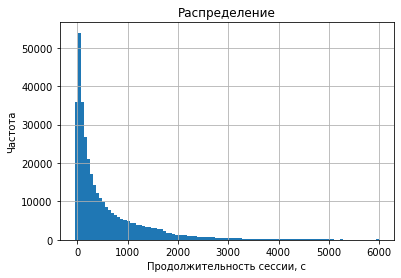

In [20]:
ax=visits['session_duration_sec'].hist(bins=100,range=(-50,6000))
plt.title('Распределение')
ax.set_xlabel('Продолжительность сессии, c')
ax.set_ylabel('Частота')
plt.show()

Из распределения видим, что есть отрицательные сессии, что не может быть правдой, поэтому надо взять mode

In [21]:
visits['session_duration_sec'].mode()

0    60
dtype: int64

В среднем одна сессия длится 60 секунд.

#### Как часто люди возвращаются?

In [22]:
first_visit_date_by_customers = visits.groupby('uid')['start_ts'].min()
first_visit_date_by_customers.name = 'first_visit_date'
visits = visits.merge(first_visit_date_by_customers,on='uid')
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]')
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')

In [23]:
visits['lifetime'] = (visits['visit_month'] - visits['first_visit_month']) / np.timedelta64(1, 'M')
visits['lifetime'] = visits['lifetime'].round().astype('int')

In [24]:
cohorts = visits.groupby(['first_visit_month','lifetime']).agg({'uid':'nunique'}).reset_index() 

In [25]:
initial_users_count = cohorts[cohorts['lifetime'] == 0][['first_visit_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 
cohorts = cohorts.merge(initial_users_count,on='first_visit_month')

In [26]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users'] 
retention_pivot = cohorts.pivot_table(index='first_visit_month',columns='lifetime',values='retention',aggfunc='sum') 

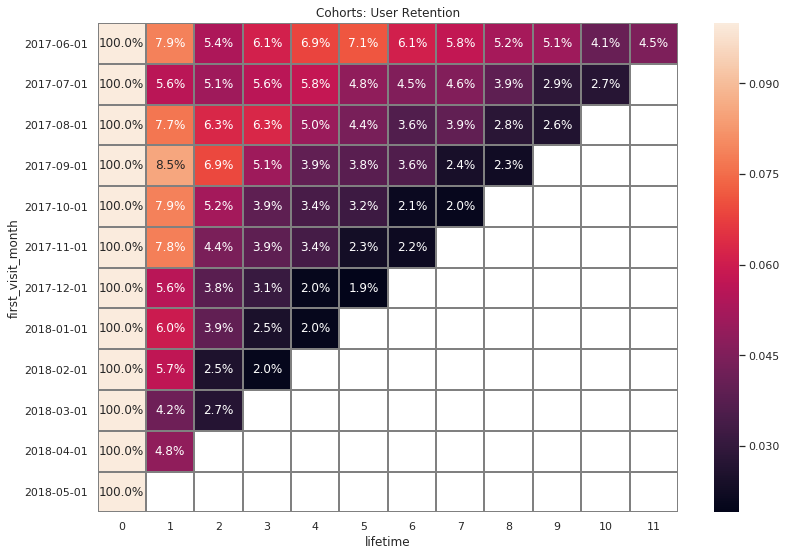

In [27]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1,vmax=0.1, linecolor='gray').set_yticklabels(retention_pivot.index.date);

В основном 92-95% людей не возвращается после первой недели, возможно дело в премьерах фильмов, а дальше процент уходящих увеличивается медленно, видимо остались ценители искусства.

### **Продажи**
 - Когда люди начинают покупать?
 - Сколько раз покупают за период?
 - Какой средний чек?
 - Сколько денег приносят? (LTV)

**Через какой промежуток люди начинают покупать????**

In [28]:
first_visit = visits.groupby('uid').agg({'start_ts':'min'})\
                .rename(columns={'start_ts':'first_visit_date'})\
                .reset_index()

In [29]:
first_order = orders.groupby('uid').agg({'buy_ts':'min'})\
                .rename(columns={'buy_ts':'first_buy_date'})\
                .reset_index()

In [30]:
time_of_purchase = first_visit.merge(first_order, on='uid', how='inner')
time_of_purchase

,uid,first_visit_date,first_buy_date
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00
...,...,...,...
36518,18445147675727495770,2017-08-20 13:30:00,2017-11-24 09:03:00
36519,18445407535914413204,2017-09-22 23:48:00,2017-09-22 23:55:00
36520,18445601152732270159,2017-08-07 11:51:00,2018-03-26 22:54:00
36521,18446156210226471712,2017-11-07 10:01:00,2018-02-18 19:34:00


In [31]:
time_of_purchase['time_of_purchase']=(time_of_purchase['first_buy_date']-time_of_purchase['first_visit_date']).dt.seconds
time_of_purchase

,uid,first_visit_date,first_buy_date,time_of_purchase
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,82920
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,4740
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,71040
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0
...,...,...,...,...
36518,18445147675727495770,2017-08-20 13:30:00,2017-11-24 09:03:00,70380
36519,18445407535914413204,2017-09-22 23:48:00,2017-09-22 23:55:00,420
36520,18445601152732270159,2017-08-07 11:51:00,2018-03-26 22:54:00,39780
36521,18446156210226471712,2017-11-07 10:01:00,2018-02-18 19:34:00,34380


In [32]:
time_of_purchase['time_of_purchase'].mode()

0    60
dtype: int64

Время покупки в среднем равно 60 секундам, но необходимо проверить нет ли 0 значений

In [33]:
time_of_purchase[time_of_purchase['time_of_purchase']==0].count()

uid                 2467
first_visit_date    2467
first_buy_date      2467
time_of_purchase    2467
dtype: int64

In [34]:
time_of_purchase['time_of_purchase'].describe()

count    36523.000000
mean     14949.881445
std      25784.567076
min          0.000000
25%        240.000000
50%        960.000000
75%      15120.000000
max      86340.000000
Name: time_of_purchase, dtype: float64

**Сколько раз покупают за период?**

In [35]:
orders_2=orders.merge(first_order)

In [36]:
orders_2['buy_ts_month']=orders_2['buy_ts'].dt.month
orders_2['buy_ts_week']=orders_2['buy_ts'].dt.week
orders_2['buy_ts_day']=orders_2['buy_ts'].dt.date
orders_2['buy_ts_year']=orders_2['buy_ts'].dt.year

In [37]:
orders_per_month=orders_2.groupby('buy_ts_month')['uid'].count()
orders_per_week=orders_2.groupby('buy_ts_week')['uid'].count()
orders_per_day=orders_2.groupby('buy_ts_day')['uid'].count()

In [38]:
orders_count = pd.DataFrame()
orders_count['per_day'] = orders_per_day.describe()
orders_count['per_week'] = orders_per_week.describe()
orders_count['per_month'] = orders_per_month.describe()

In [39]:
day_purchases_per_user = orders_2.groupby(['buy_ts_day', 'uid']).agg({'buy_ts':'count'}).mean()[0]
week_purchases_per_user = orders_2.groupby(['buy_ts_year', 'buy_ts_week', 'uid']).agg({'buy_ts':'count'}).mean()[0]
month_purchases_per_user = orders_2.groupby(['buy_ts_month', 'uid']).agg({'buy_ts':'count'}).mean()[0]

Количество заказов в среднем на одного пользователя за день

In [40]:
day_purchases_per_user

1.0830755349316834

Количество заказов в среднем на одного пользователя за неделю

In [41]:
week_purchases_per_user

1.1643724883366438

Количество заказов в среднем на одного пользователя за месяц

In [42]:
month_purchases_per_user

1.2290645798288597

**Какой средний чек?**

In [43]:
summa_purchase_by_month = orders_2.groupby('buy_ts_month').agg({'revenue': 'sum'})
summa_purchase_by_month

,revenue
buy_ts_month,
1,19417.13
2,25560.54
3,28834.59
4,16858.06
5,20735.98
6,9560.91
7,12539.47
8,8758.78
9,18345.51


In [44]:
buyers=orders_2.groupby('buy_ts_month').agg({'uid': 'nunique'})
buyers

,uid
buy_ts_month,
1,3898
2,4258
3,4181
4,2744
5,3544
6,2024
7,1984
8,1472
9,2750


In [45]:
average_order_value=summa_purchase_by_month.merge(buyers,on='buy_ts_month')
average_order_value

,revenue,uid
buy_ts_month,,
1,19417.13,3898
2,25560.54,4258
3,28834.59,4181
4,16858.06,2744
5,20735.98,3544
6,9560.91,2024
7,12539.47,1984
8,8758.78,1472
9,18345.51,2750


In [46]:
average_order_value['average_check']=average_order_value['revenue']/average_order_value['uid']
average_order_value

,revenue,uid,average_check
buy_ts_month,,,
1,19417.13,3898,4.981306
2,25560.54,4258,6.002945
3,28834.59,4181,6.896577
4,16858.06,2744,6.143608
5,20735.98,3544,5.851010
6,9560.91,2024,4.723770
7,12539.47,1984,6.320297
8,8758.78,1472,5.950258
9,18345.51,2750,6.671095


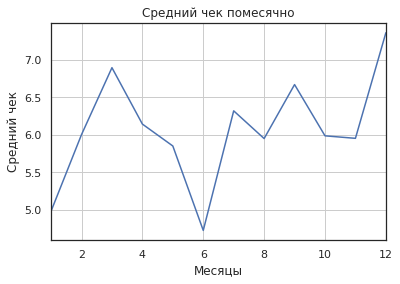

In [70]:
ax=average_order_value['average_check'].plot(grid=True)
plt.title('Средний чек помесячно')
ax.set_xlabel('Месяцы')
ax.set_ylabel('Средний чек')
plt.show()

Из графика, можно сделать вывод, что в декабре перед праздниками покупатели тратят больше всего денег.

In [48]:
orders_2['revenue'].mean()

4.999646930477041

Средний чек равен - 5

**Сколько денег приносят? (LTV)**

In [49]:
orders_monthly = orders.copy()
orders_monthly['date_of_purchase'] = orders_monthly['buy_ts'].astype('datetime64[M]') 
orders_monthly

,buy_ts,revenue,uid,date_of_purchase
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01
...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01


In [50]:
first_orders_month = orders_monthly.groupby('uid').agg({'date_of_purchase': 'min'}).reset_index()
first_orders_month.columns = ['uid', 'first_purchase_date']

cohort_sizes = first_orders_month.groupby('first_purchase_date').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_purchase_date', 'n_buyers']

margin_rate = 1

orders_first_orders_month = orders_monthly.merge(first_orders_month, on='uid')
cohorts = (orders_first_orders_month
                                .groupby(['date_of_purchase', 'first_purchase_date'])
                                .agg({'revenue': 'sum'})
                                .reset_index()
              )

ltv = cohorts.merge(cohort_sizes, on='first_purchase_date')

ltv['gp'] = ltv['revenue'] * margin_rate
ltv['age'] = (ltv['date_of_purchase'] - ltv['first_purchase_date']) / np.timedelta64(1, 'M')
ltv['age'] = ltv['age'].round().astype('int')
ltv['ltv'] = ltv['gp'] / ltv['n_buyers']
   
ltv_pivot = ltv.pivot_table(index="first_purchase_date",
                columns="age",
                values="ltv",
                aggfunc='mean')

ltv_pivot.fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_date,,,,,,,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.02253,0.735502,0.95044,0.581592,0.553213,0.605788,0.571261,0.256856
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208,0.14182,0.161232,0.147145,0.155673,
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.28354,0.210664,0.405007,0.292212,0.187978,,
2017-09-01,5.644529,1.11759,0.52093,3.97579,0.400558,0.647067,0.701608,0.24315,0.184006,,,
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.15156,0.120362,0.0848157,0.11547,,,,
2017-11-01,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.114928,,,,,
2017-12-01,4.738191,0.260374,0.925097,1.06527,0.31293,0.338047,,,,,,
2018-01-01,4.135636,0.294758,0.304281,0.142778,0.0626979,,,,,,,
2018-02-01,4.156987,0.278274,0.0785155,0.0741441,,,,,,,,


In [51]:
ltv

,date_of_purchase,first_purchase_date,revenue,n_buyers,gp,age,ltv
0,2017-06-01,2017-06-01,9557.49,2023,9557.49,0,4.724414
1,2017-07-01,2017-06-01,981.82,2023,981.82,1,0.485329
2,2017-08-01,2017-06-01,885.34,2023,885.34,2,0.437637
3,2017-09-01,2017-06-01,1931.30,2023,1931.30,3,0.954671
4,2017-10-01,2017-06-01,2068.58,2023,2068.58,4,1.022531
...,...,...,...,...,...,...,...
74,2018-05-01,2018-03-01,1114.87,3533,1114.87,2,0.315559
75,2018-04-01,2018-04-01,10600.69,2276,10600.69,0,4.657597
76,2018-05-01,2018-04-01,1209.92,2276,1209.92,1,0.531599
77,2018-05-01,2018-05-01,13925.76,2988,13925.76,0,4.660562


### **Маркетинг**
 - Сколько денег потратили? Всего / на каждый источник / по времени
 - Сколько стоило привлечение одного покупателя из каждого источника?
 - На сколько окупились расходы? (ROI)
 
Отобразите на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?

#### Сколько денег потратили? Всего / на каждый источник / по времени

In [52]:
costs['costs'].sum()

329131.62

In [53]:
costs_by_source=costs.groupby('source_id')['costs'].sum().reset_index()
costs_by_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [54]:
costs_by_source['in_percents'] = costs_by_source['costs'] / costs['costs'].sum() * 100

In [55]:
costs_by_source.sort_values('in_percents', ascending = False)

,source_id,costs,in_percents
2,3,141321.63,42.937725
3,4,61073.60,18.555981
4,5,51757.10,15.725350
1,2,42806.04,13.005751
0,1,20833.27,6.329769
6,10,5822.49,1.769046
5,9,5517.49,1.676378


Больше всего вкладывали в 3 источник 

In [56]:
costs['costs_month'] = costs['dt'].astype('datetime64[M]').dt.date

In [57]:
costs_by_month=costs.groupby('costs_month')['costs'].sum().reset_index()
costs_by_month

,costs_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


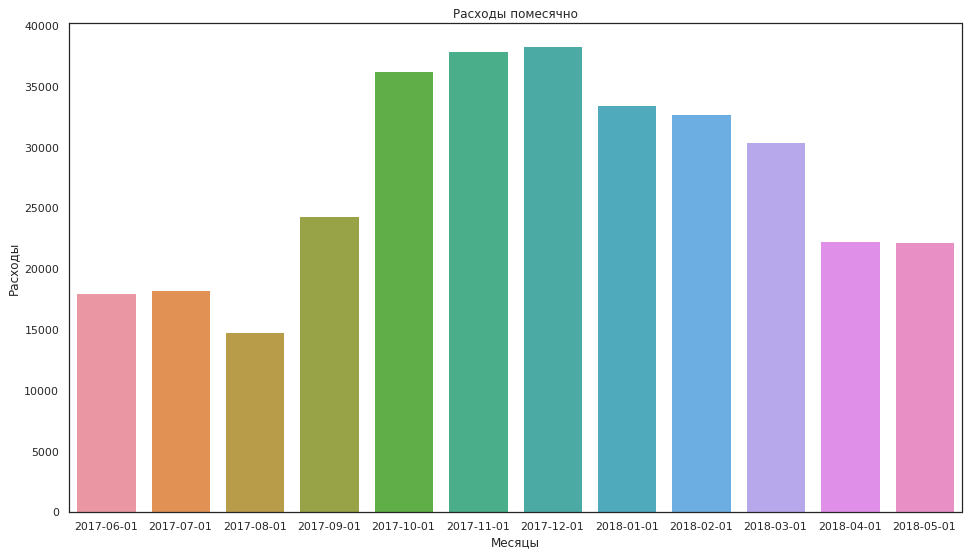

In [58]:
plt.figure(figsize = (16, 9))
ax = sns.barplot(x="costs_month", y="costs", data=costs_by_month)
plt.title('Расходы помесячно')
ax.set_xlabel('Месяцы')
ax.set_ylabel('Расходы')
plt.show()

Cамый расходные месяцы октябрь, ноябрь и декабрь предположительно из-за приближающихся праздников

**Сколько стоило привлечение одного покупателя из каждого источника?**

In [59]:
costs_by_source = costs.groupby('source_id').agg({'costs':'sum'})
costs_by_source.reset_index()

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [60]:
visits_by_source = visits.query('start_ts == first_visit_date')
customers_by_source = (orders.merge(visits_by_source, on='uid', how='inner')).groupby('source_id').agg({'uid':'nunique'})\
                        .rename(columns={'uid':'customers'})
customers_by_source.reset_index()

,source_id,customers
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


In [61]:
cac = customers_by_source.join(costs_by_source).reset_index()
cac.fillna(0)

,source_id,customers,costs
0,1,2899,20833.27
1,2,3506,42806.04
2,3,10473,141321.63
3,4,10296,61073.60
4,5,6931,51757.10
5,7,1,0.00
6,9,1088,5517.49
7,10,1329,5822.49


In [62]:
cac['cac'] = cac['costs'] / cac['customers']
cac

,source_id,customers,costs,cac
0,1,2899,20833.27,7.186364
1,2,3506,42806.04,12.209367
2,3,10473,141321.63,13.493901
3,4,10296,61073.60,5.931779
4,5,6931,51757.10,7.467479
5,7,1,NaN,NaN
6,9,1088,5517.49,5.071222
7,10,1329,5822.49,4.381106


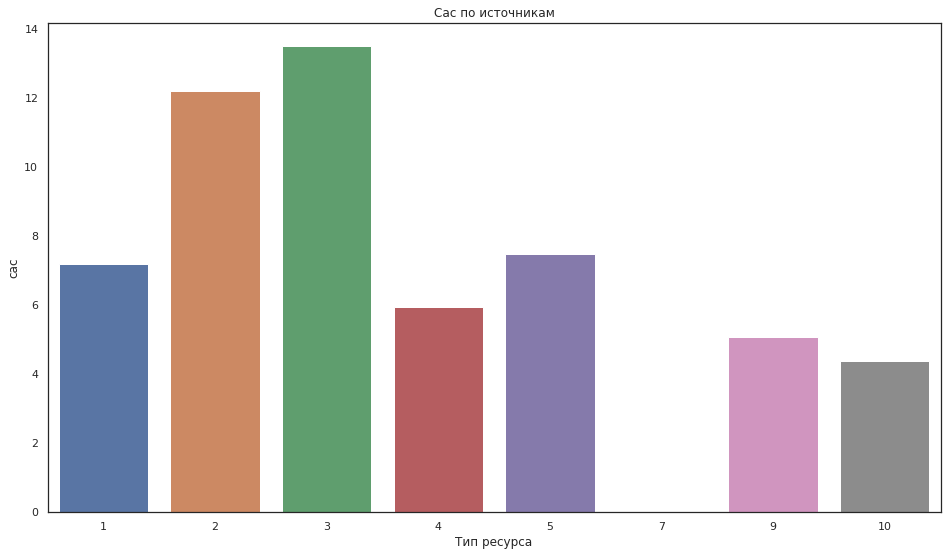

In [63]:
plt.figure(figsize = (16, 9))
ax = sns.barplot(x="source_id", y="cac", data=cac)
plt.title('Cac по источникам')
ax.set_xlabel('Тип ресурса')
ax.set_ylabel('сас')
plt.show()

Дороже всего обошлись источники 2 и 3, про 7 ничего нет, самый дешевый 10

#### На сколько окупились расходы? (ROI)

In [64]:
costs_by_source.reset_index()

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [65]:
revenue_by_source = (orders.merge(visits_by_source, on='uid', how='inner')).groupby('source_id').agg({'revenue':'sum'})
revenue_by_source.reset_index()

,source_id,revenue
0,1,31090.55
1,2,46923.61
2,3,54511.24
3,4,56696.83
4,5,52624.02
5,7,1.22
6,9,5759.40
7,10,4450.33


In [66]:
roi = revenue_by_source.join(costs_by_source)
roi['roi'] = (roi['revenue'] - roi['costs']) / roi['costs']

In [67]:
roi.sort_values('roi', ascending = False)

,revenue,costs,roi
source_id,,,
1,31090.55,20833.27,0.492351
2,46923.61,42806.04,0.096191
9,5759.40,5517.49,0.043844
5,52624.02,51757.10,0.016750
4,56696.83,61073.60,-0.071664
10,4450.33,5822.49,-0.235665
3,54511.24,141321.63,-0.614275
7,1.22,NaN,NaN


Лучше всего окупается источник 1, в то время как источники 3,4,10 ушли в минус, а про 7 вооьбще нет полной информации.

In [68]:
revenue_by_source_and_device = (orders.merge(visits_by_source, on='uid', how='inner'))\
                                .groupby(['source_id', 'device']).agg({'revenue':'sum'}).reset_index()

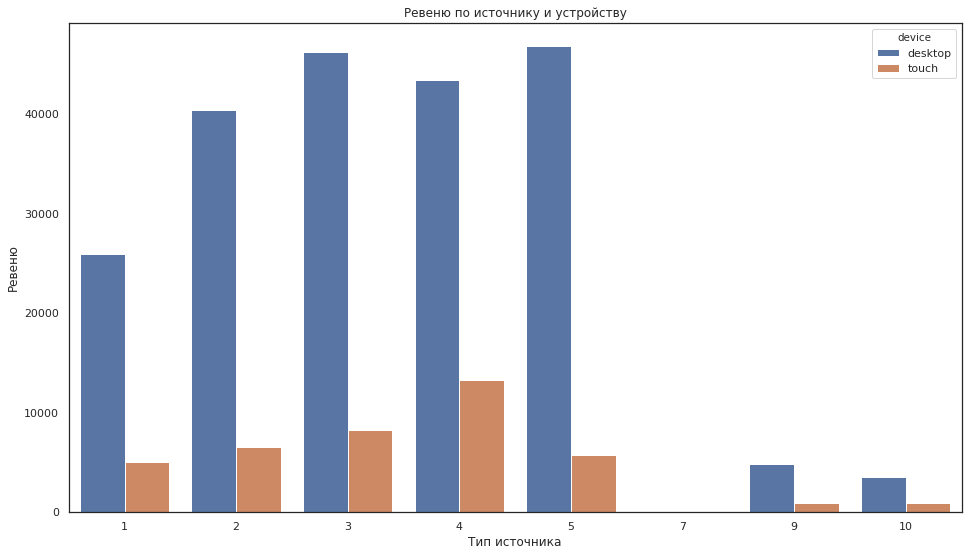

In [69]:
plt.figure(figsize = (16, 9))
ax = sns.barplot(x="source_id", y="revenue", hue="device", data=revenue_by_source_and_device)
plt.title('Ревеню по источнику и устройству')
ax.set_xlabel('Тип источника')
ax.set_ylabel('Ревеню')
plt.show()

## Выводы

Стоило бы перестать использовать канал 3, т.к. в него больше всего вкладывают для привлечения клиентов, но он все равно ушел в минус по доходам. А начать вкладывать в 1 и 5, эти источники хорошо окупаются(ROMI), учитывая нынешние вложения. Так же стоит рассмотреть источник 7 о котором недостаточно информации и провести допольничтельные исследования источников 2,9, у которых хорошая окупаемость.

Исходя из когортного анализа, большая часть людей после первой покупки не возвращается, а проводят люди на сайте в среднем минуту, успевая при этом что-то купить.